In [1]:
csv_path = "/home/ali/Datasets/Fitz17k/fitzpatrick17k_preprocessed.csv"
main_br_path = "/home/ali/Outputs/SkinFormer_baseline_3class/DiT_S_LRP_level=high_checkpoint_BASE.pth"
SA_br_path = "/home/ali/Outputs/SkinFormer_2SABranch/DiT_S_LRP_2SABranch_checkpoint.pth"
root_image_dir = "/home/ali/Datasets/Fitz17k/Images/"

# Visualization code

In [2]:
import os
import skimage
from skimage import io
import torch
import pandas as pd
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from PIL import Image


In [3]:
def generate_visualization(attribution_generator, original_image, class_index=None):

    transformer_attribution = attribution_generator.generate_LRP(
        input=original_image.unsqueeze(0).cuda(),
        method="transformer_attribution",
        index=class_index,
    )[0].detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(
        transformer_attribution, scale_factor=16, mode="bilinear"
    )
    transformer_attribution = (
        transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    )
    transformer_attribution = (
        transformer_attribution - transformer_attribution.min()
    ) / (transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (
        image_transformer_attribution - image_transformer_attribution.min()
    ) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis


# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam


In [4]:
import sys
sys.path.append('..') 
from Datasets.datasets import Fitz17kDataset

fitz_dataset = Fitz17kDataset(
        df=pd.read_csv(csv_path),
        root_dir=root_image_dir,
        transform=transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize(size=256),
                transforms.CenterCrop(size=224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        ),
    )

In [5]:
from Models.ViT_LRP.ViT_LRP import deit_small_patch16_224

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

main_model = deit_small_patch16_224(
    pretrained=False,
    num_classes=3,
    add_hook=True,
    weight_path=main_br_path,
)
main_model = main_model.eval().to(device)

SA_model = deit_small_patch16_224(
    pretrained=False,
    num_classes=2,
    add_hook=True,
    weight_path=SA_br_path,
)
SA_model = SA_model.eval().to(device)

Weights load from /home/ali/Outputs/SkinFormer_baseline_3class/DiT_S_LRP_level=high_checkpoint_BASE.pth
Weights load from /home/ali/Outputs/SkinFormer_2SABranch/DiT_S_LRP_2SABranch_checkpoint.pth


# Visualization

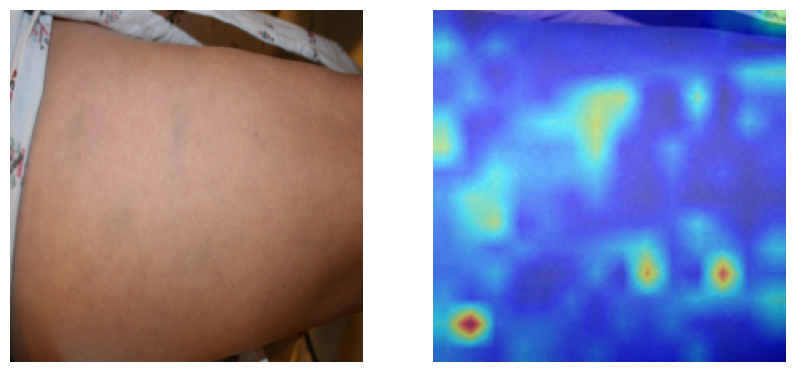

In [6]:
sample = fitz_dataset[0]
image = sample["image"]
label = sample["high"]
fitz = sample["fitzpatrick"]

main_vis = generate_visualization(main_model, image, class_index=torch.tensor([label]))
image = Image.open(os.path.join(root_image_dir, sample['hasher']+".jpg"))
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
image = simple_transform(image).permute(1, 2, 0)

fig, axs = plt.subplots(1, 2, figsize=(10, 30))
axs[0].imshow(image);
axs[0].axis("off");
axs[1].imshow(main_vis);
axs[1].axis("off");

In [10]:
df = pd.read_csv(csv_path)
df
indices = []
for fitz in range(6):
  filtered_df = df[df["fitzpatrick"]==fitz]
  indices.append(random.choice(filtered_df.index))

In [8]:
indices = [0,1,2,3,4,5]

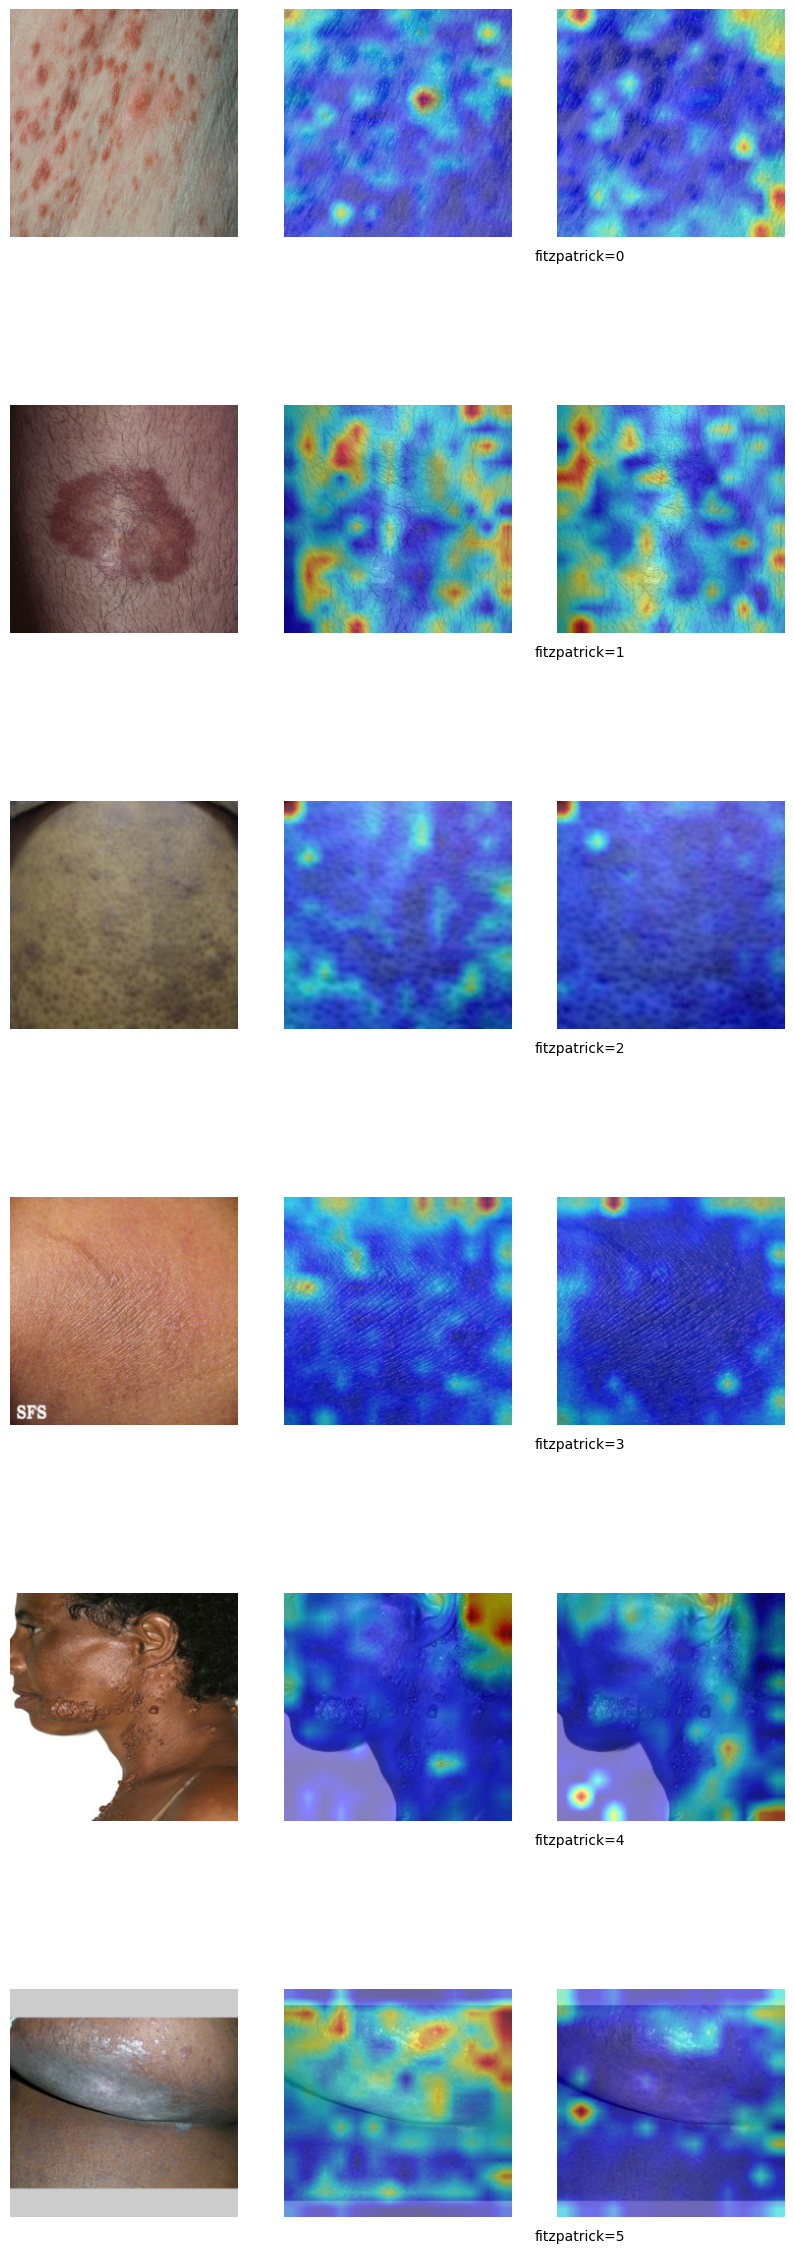

In [11]:
fig, axs = plt.subplots(6, 3, figsize=(10, 30))
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


for i, idx in enumerate(indices):
  sample = fitz_dataset[idx]
  image = sample["image"]
  label = sample["high"]
  fitz = sample["fitzpatrick_binary"]


  main_vis = generate_visualization(main_model, image, class_index=label)
  SA_vis = generate_visualization(SA_model, image, class_index=fitz)


  image = Image.open(os.path.join(root_image_dir, sample['hasher']+".jpg"))
  image = simple_transform(image).permute(1, 2, 0)

  axs[i][0].imshow(image);
  axs[i][0].axis("off");
  axs[i][1].imshow(main_vis);
  axs[i][1].axis("off");
  axs[i][2].imshow(SA_vis);
  axs[i][2].axis("off");
  axs[i][0].text(2.5, -0.1, "fitzpatrick={}".format(sample["fitzpatrick"]), transform=axs[i][0].transAxes, ha="center");